In [472]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as gbm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from pickle import dump, load

### Get data
After reading the file we see that there are a lot of nin numerical data. To train a machine learning model we need to process them and convert to numbers.

In [191]:
df = pd.read_csv("par_listings.csv", index_col='id')
df.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar

In [212]:
df = pd.read_csv("par_listings.csv", index_col='id')

#delete unnecessary columns
columns = ['listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'host_id',
           'description', 'name', 'neighborhood_overview', 'picture_url', 'host_acceptance_rate',
           'host_url', 'host_name', 'host_about', 'host_since',
           'host_thumbnail_url', 'host_picture_url',
           'host_neighbourhood', 'host_listings_count', 'host_verifications',
           'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_group_cleansed', 
        'minimum_minimum_nights','maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'host_location',
       'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60',
       'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
        'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms', 'instant_bookable', 'has_availability', 
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']
df.drop(columns, axis=1, inplace=True)
df.rename(columns={"neighbourhood_cleansed":"neighbourhood"}, inplace=True)

#delete non popular categories
df = df.groupby("property_type").filter(lambda x: len(x) > 100)
df = df.groupby("neighbourhood").filter(lambda x: len(x) > 100)

df.replace({'f': 0, 't': 1}, inplace=True)
# convert dtype to category
df.room_type = df.room_type.astype('category')
df.property_type = df.property_type.astype('category')
df.neighbourhood = df.neighbourhood.astype('category')

# convert from obj to float
df["bathrooms_text"].replace("Shared half-bath", "1 shared bath", inplace=True)
df["bathrooms_text"].replace("Private half-bath", "1 bath", inplace=True)
df["bathrooms_text"].replace("Half-bath", "1 bath", inplace=True)
df["bathrooms"] = df["bathrooms_text"].apply(lambda row: float(str(row).split(' ')[0]))
df.bathrooms.fillna(0, inplace=True)
df.drop(["bathrooms_text"], axis=1, inplace=True)

#convert target: price
df.price.replace(",", "", inplace=True, regex=True)
df.price = df.price.apply(lambda row: float(str(row)[1:]))
df.loc[df.price < 10, 'price'] = 10
df.loc[df.price > 1000, 'price'] = 1000

df.first_review = pd.to_datetime(df.first_review) # Converting to datetime
df.last_review = pd.to_datetime(df.last_review)
# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2023, 1, 2) - df.first_review).astype('timedelta64[D]')
df['time_since_last_review'] = (datetime(2023, 1, 2) - df.last_review).astype('timedelta64[D]')

df.host_response_time.fillna("unknown", inplace=True)
df.dropna(subset=['host_total_listings_count', 'beds'], inplace=True)
df.bathrooms.fillna(df['bathrooms'].median(), inplace=True)
df.bedrooms.fillna(df['bedrooms'].median(), inplace=True)
df.host_is_superhost.fillna(0, inplace=True)

df.property_type.replace({
    'Room in aparthotel': 'Room in hotel',
    'Private room in bed and breakfast': 'Room in hotel',
    'Private room in home': 'Private room in rental unit',
    'Private room in townhouse': 'Private room in rental unit',
    'Private room in loft': 'Private room in rental unit',
    'Entire serviced apartment': 'Entire rental unit',
    }, inplace=True)

bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

df.property_type.replace({
    'Room in aparthotel': 'Room in hotel',
    'Private room in bed and breakfast': 'Room in hotel',
    'Private room in home': 'Private room in rental unit',
    'Private room in townhouse': 'Private room in rental unit',
    'Private room in loft': 'Private room in rental unit',
    'Entire serviced apartment': 'Entire rental unit',
    }, inplace=True)

df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)
df.host_response_rate = df.host_response_rate.astype('str')
df.host_response_rate.replace('nan', 'unknown', inplace=True)

df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:, 26:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:, 26:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)

df.drop(infrequent_amenities, axis=1, inplace=True)
df.drop('amenities', axis=1, inplace=True)
df.drop(columns=['first_review', "last_review"], inplace=True)

In [445]:
df.columns

Index(['host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'neighbourhood', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'calculated_host_listings_count', 'time_since_first_review',
       'time_since_last_review', 'air_conditioning', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance'],
      dtype='object')

In [148]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

### Encode categorical features
Encode room type, property type and neighbourhood using one hot encoding.

In [214]:
df_ = pd.get_dummies(df)
# df = pd.concat([df, onehot], axis=1)
# df.drop(columns=["room_type", "property_type", "neighbourhood", "amenities"], inplace=True)
# df.columns = df.columns.str.replace(" ", "_", regex=True)

In [215]:
df_.columns

Index(['host_is_superhost', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'availability_90',
       'number_of_reviews', 'review_scores_accuracy',
       'calculated_host_listings_count', 'air_conditioning', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator',
       'parking', 'host_greeting', 'internet', 'long_term_stays',
       'private_entrance', 'host_response_time_a few days or more',
       'host_response_time_unknown', 'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_rate_0-49%',
       'host_response_rate_100%', 'host_response_rate_50-89%',
       'host_response_rate_90-99%', 'host_response_rate_unknown',
       'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse',
       'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Mo

In [474]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    sns.set(style="white")
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(100, 10, as_cmap=True)
    sns.heatmap(corr, 
                mask=mask, 
                cmap=cmap, 
                center=0, 
                square=True, 
                linewidths=.5, 
                cbar_kws={"shrink": .5}, 
                vmax=corr[corr != 1.0].max().max());

In [479]:
df_.columns

Index(['host_is_superhost', 'host_total_listings_count', 'latitude',
       'longitude', 'accommodates', 'bathrooms', 'price', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'review_scores_accuracy', 'calculated_host_listings_count',
       'air_conditioning', 'bed_linen', 'tv', 'coffee_machine',
       'cooking_basics', 'white_goods', 'elevator', 'parking', 'host_greeting',
       'internet', 'long_term_stays', 'private_entrance',
       'host_response_time_a few days or more', 'host_response_time_unknown',
       'host_response_time_within a day',
       'host_response_time_within a few hours',
       'host_response_time_within an hour', 'host_response_rate_100%',
       'host_response_rate_50-89%', 'host_response_rate_90-99%',
       'neighbourhood_Batignolles-Monceau', 'neighbourhood_Bourse',
       'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
       'neighbourhood_Entrepôt', 'neighbourhood_Gobelins',
       'neighbo

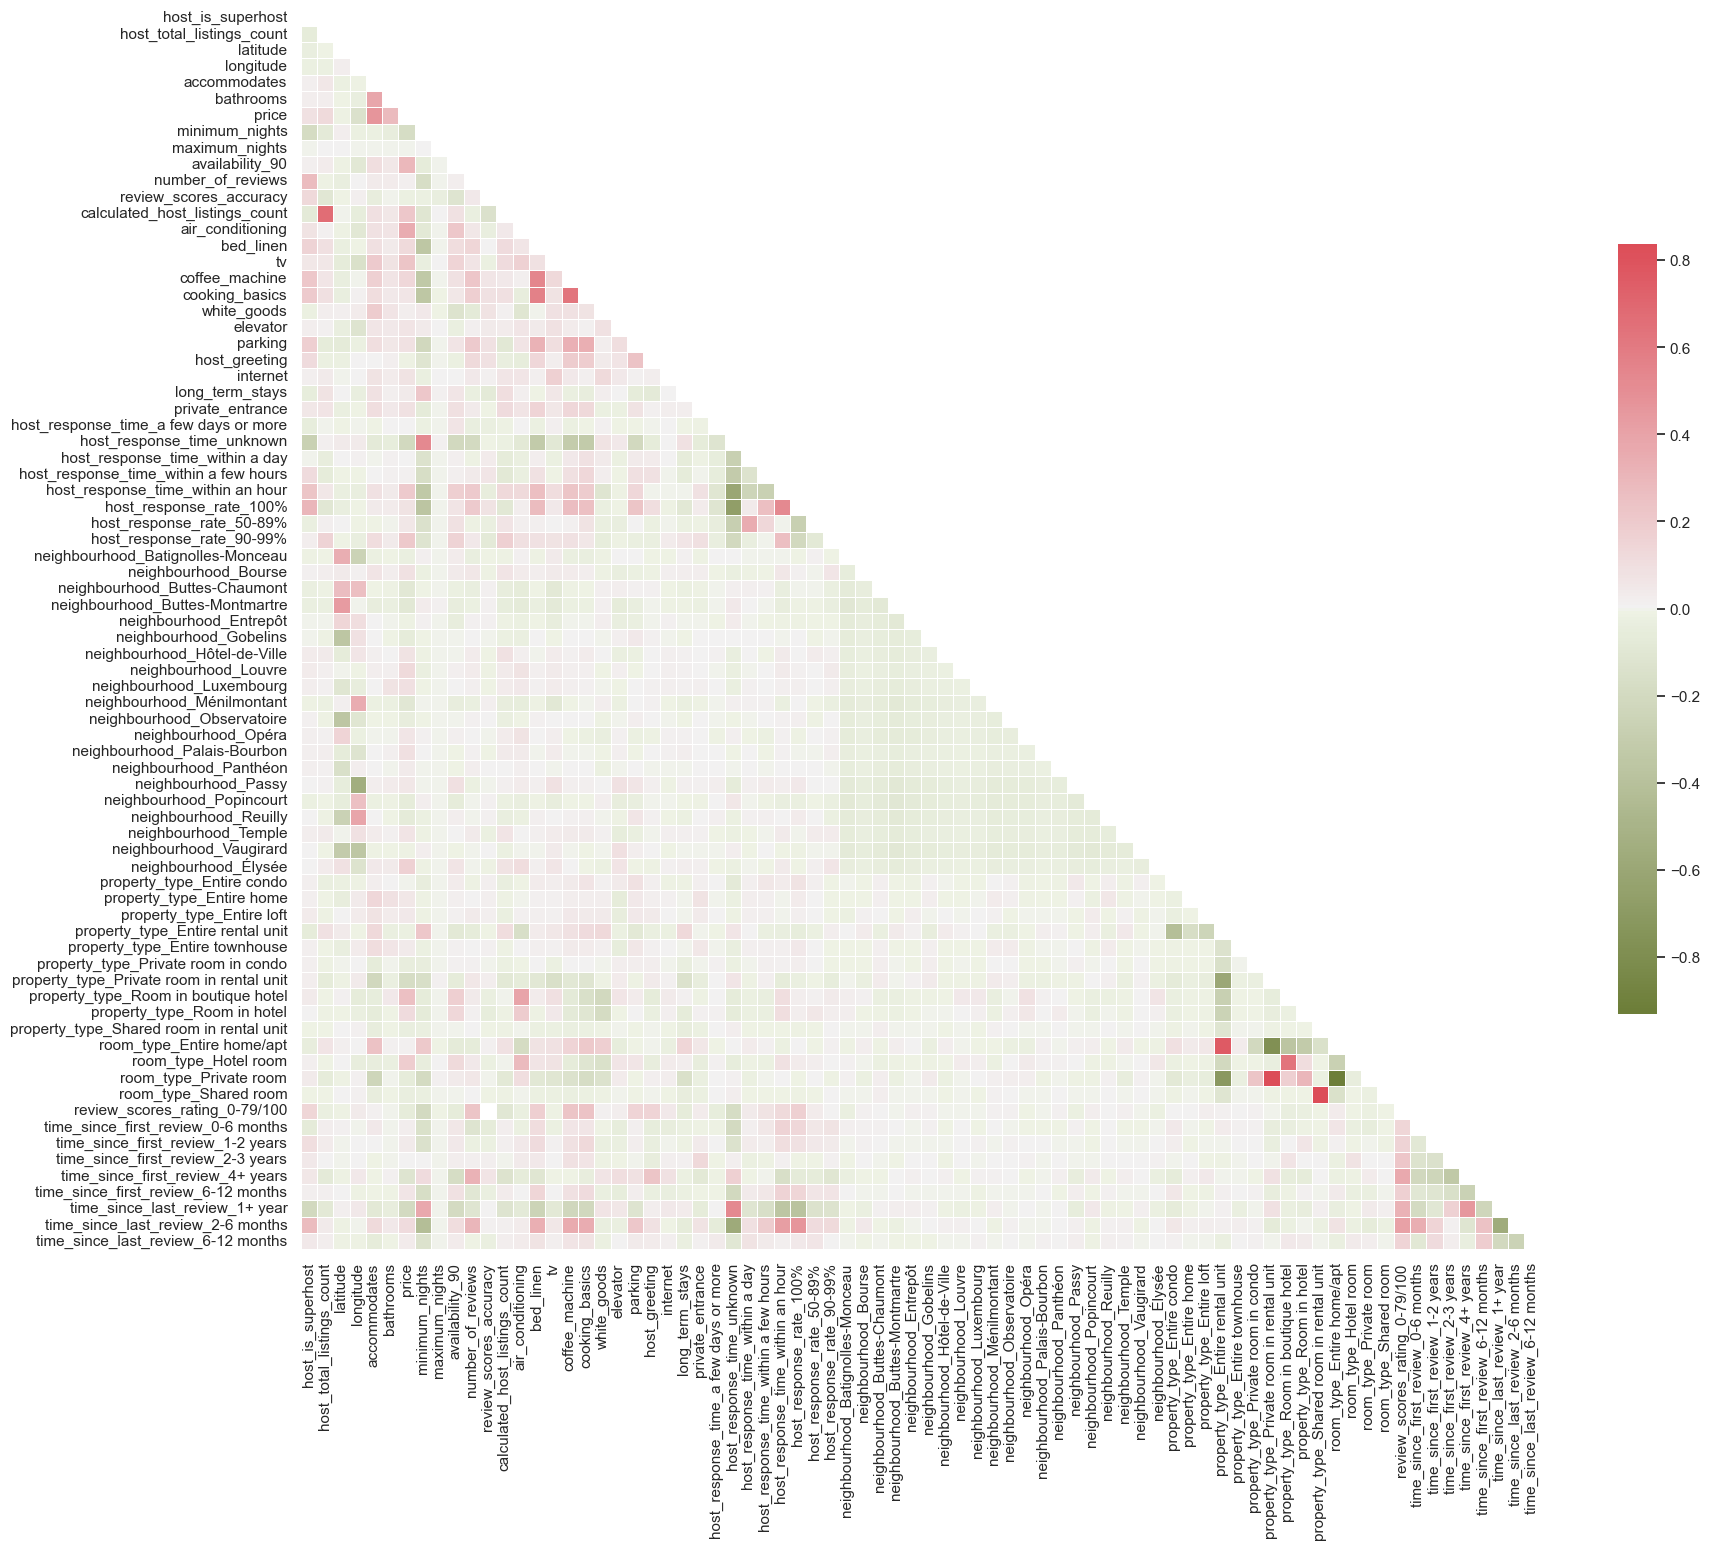

In [475]:
multi_collinearity_heatmap(df_, figsize=(20,20))

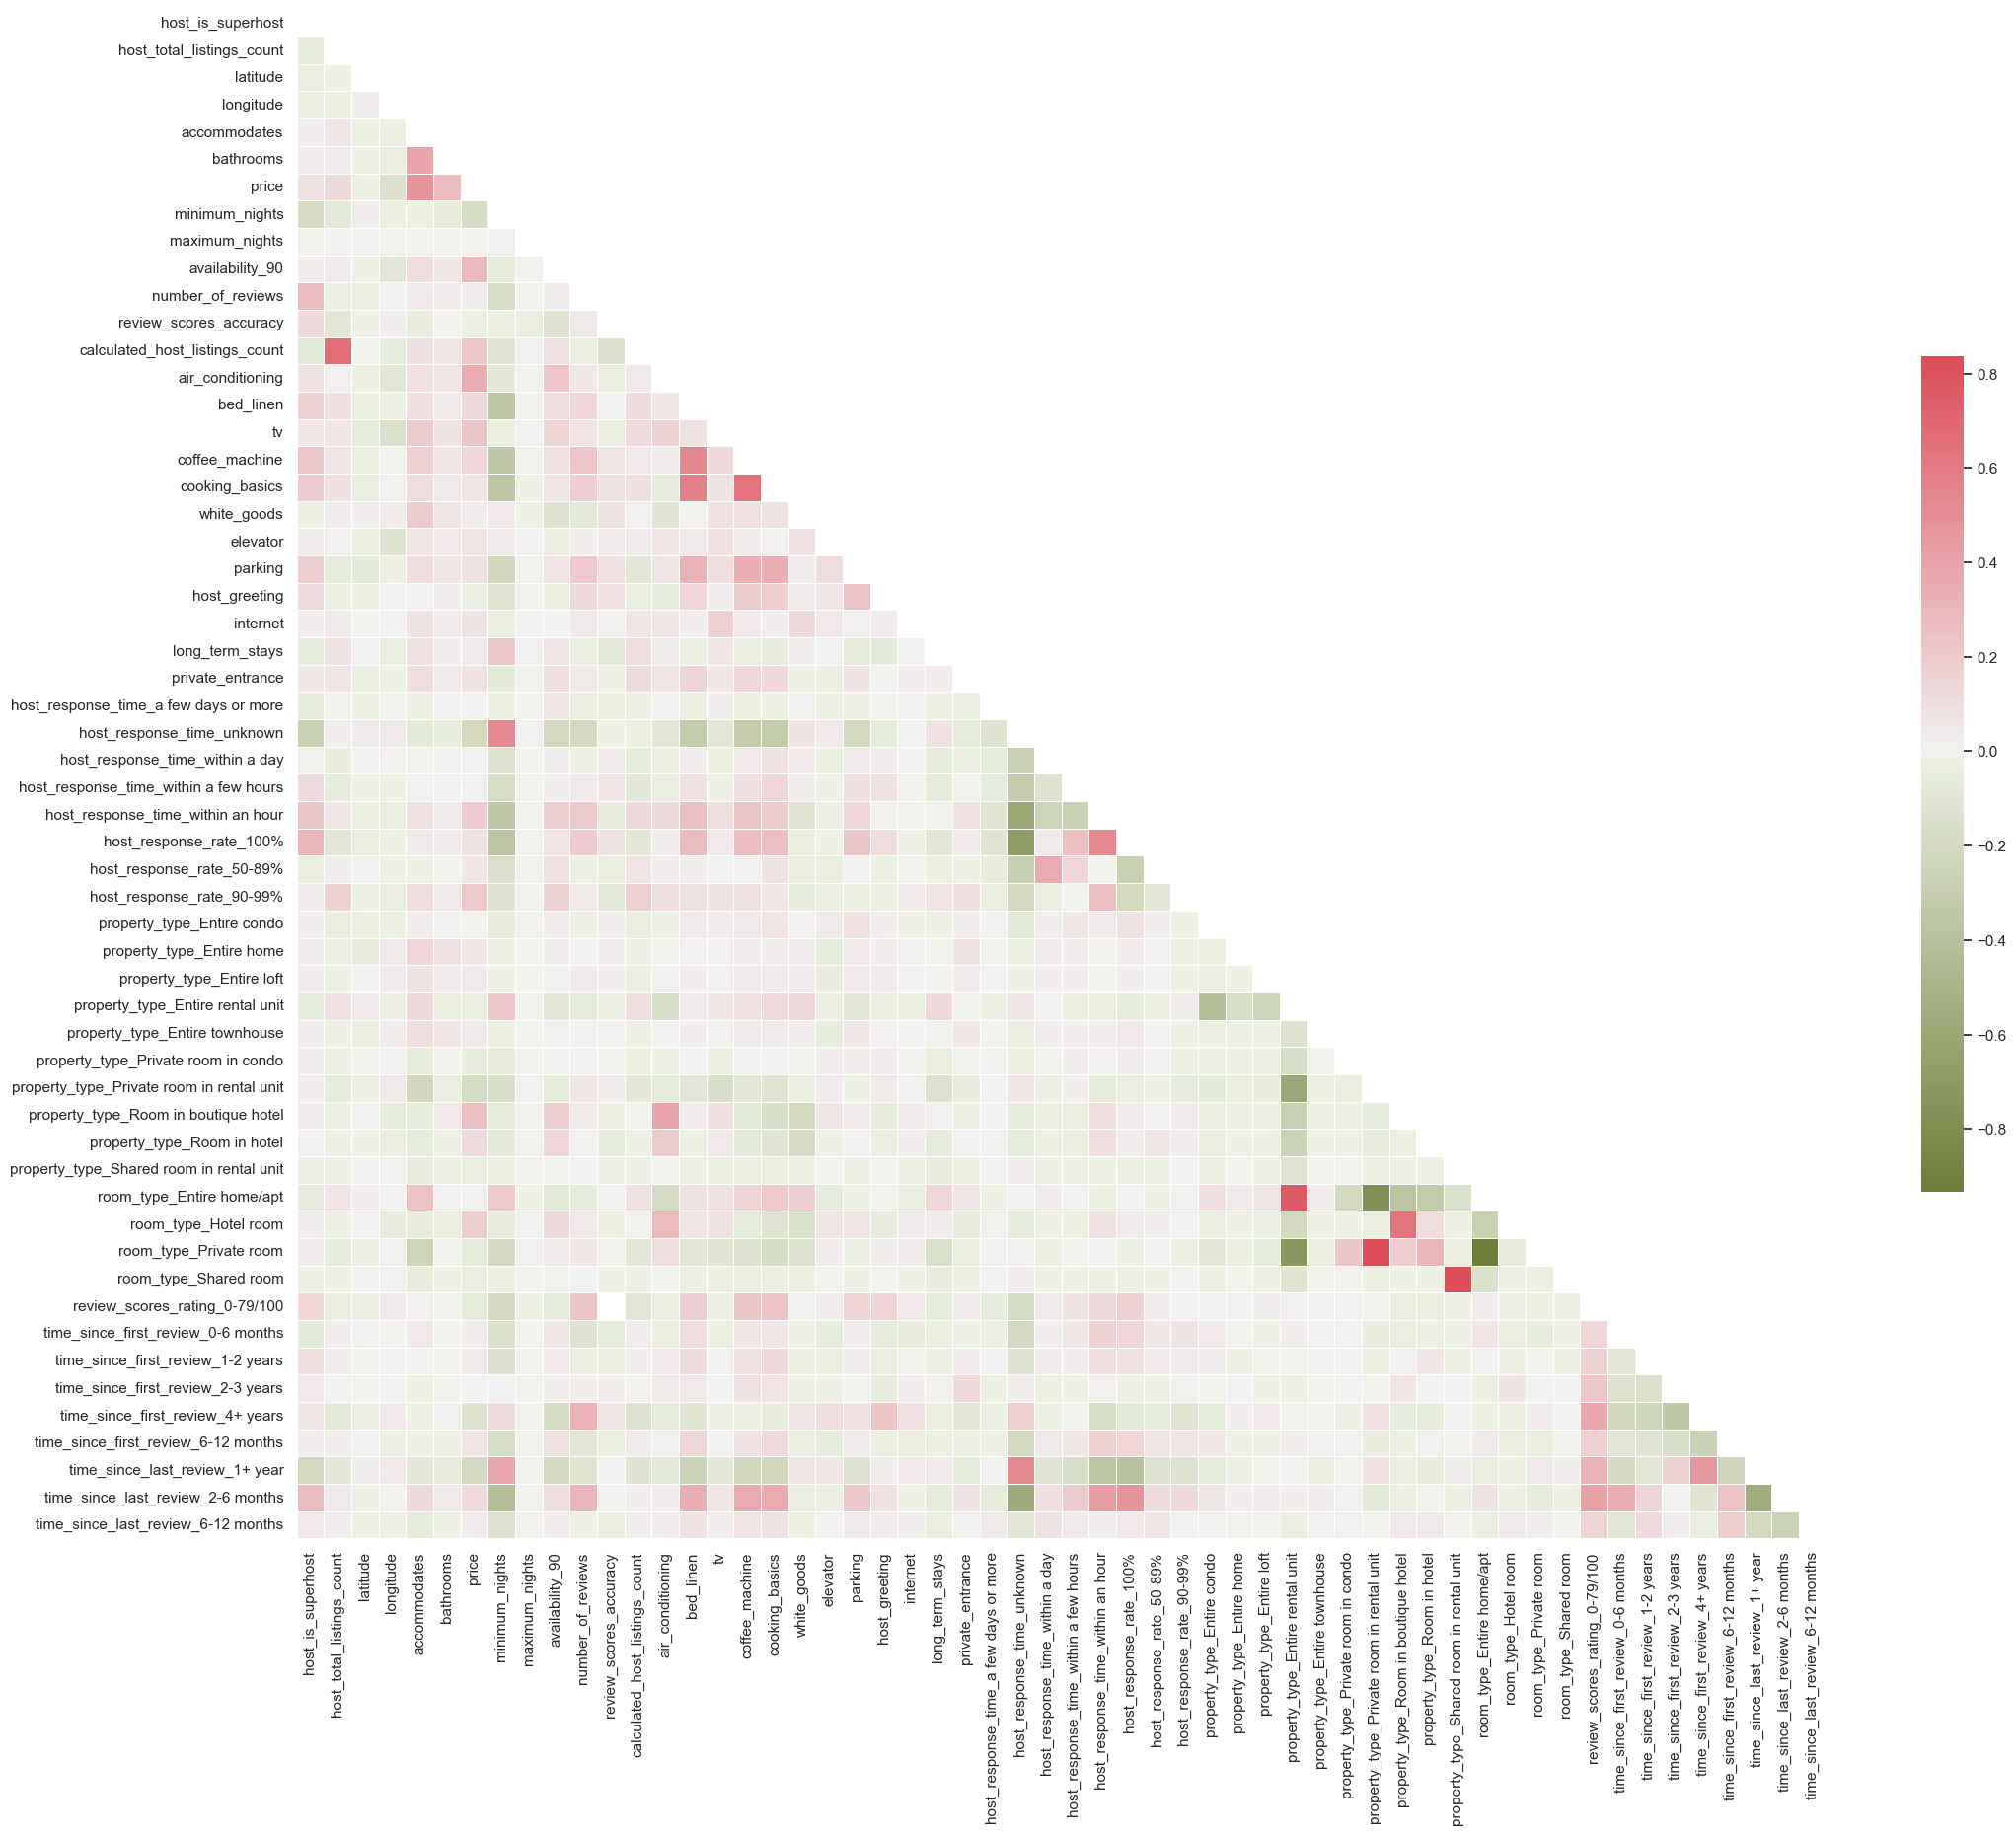

In [476]:
multi_collinearity_heatmap(df_.drop(list(df_.columns[df_.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25, 22))

In [218]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'host_response_rate_unknown',
           'host_response_rate_0-49%']
to_drop.extend(list(df_.columns[df_.columns.str.endswith('nan')]))

df_.drop(to_drop, axis=1, inplace=True)

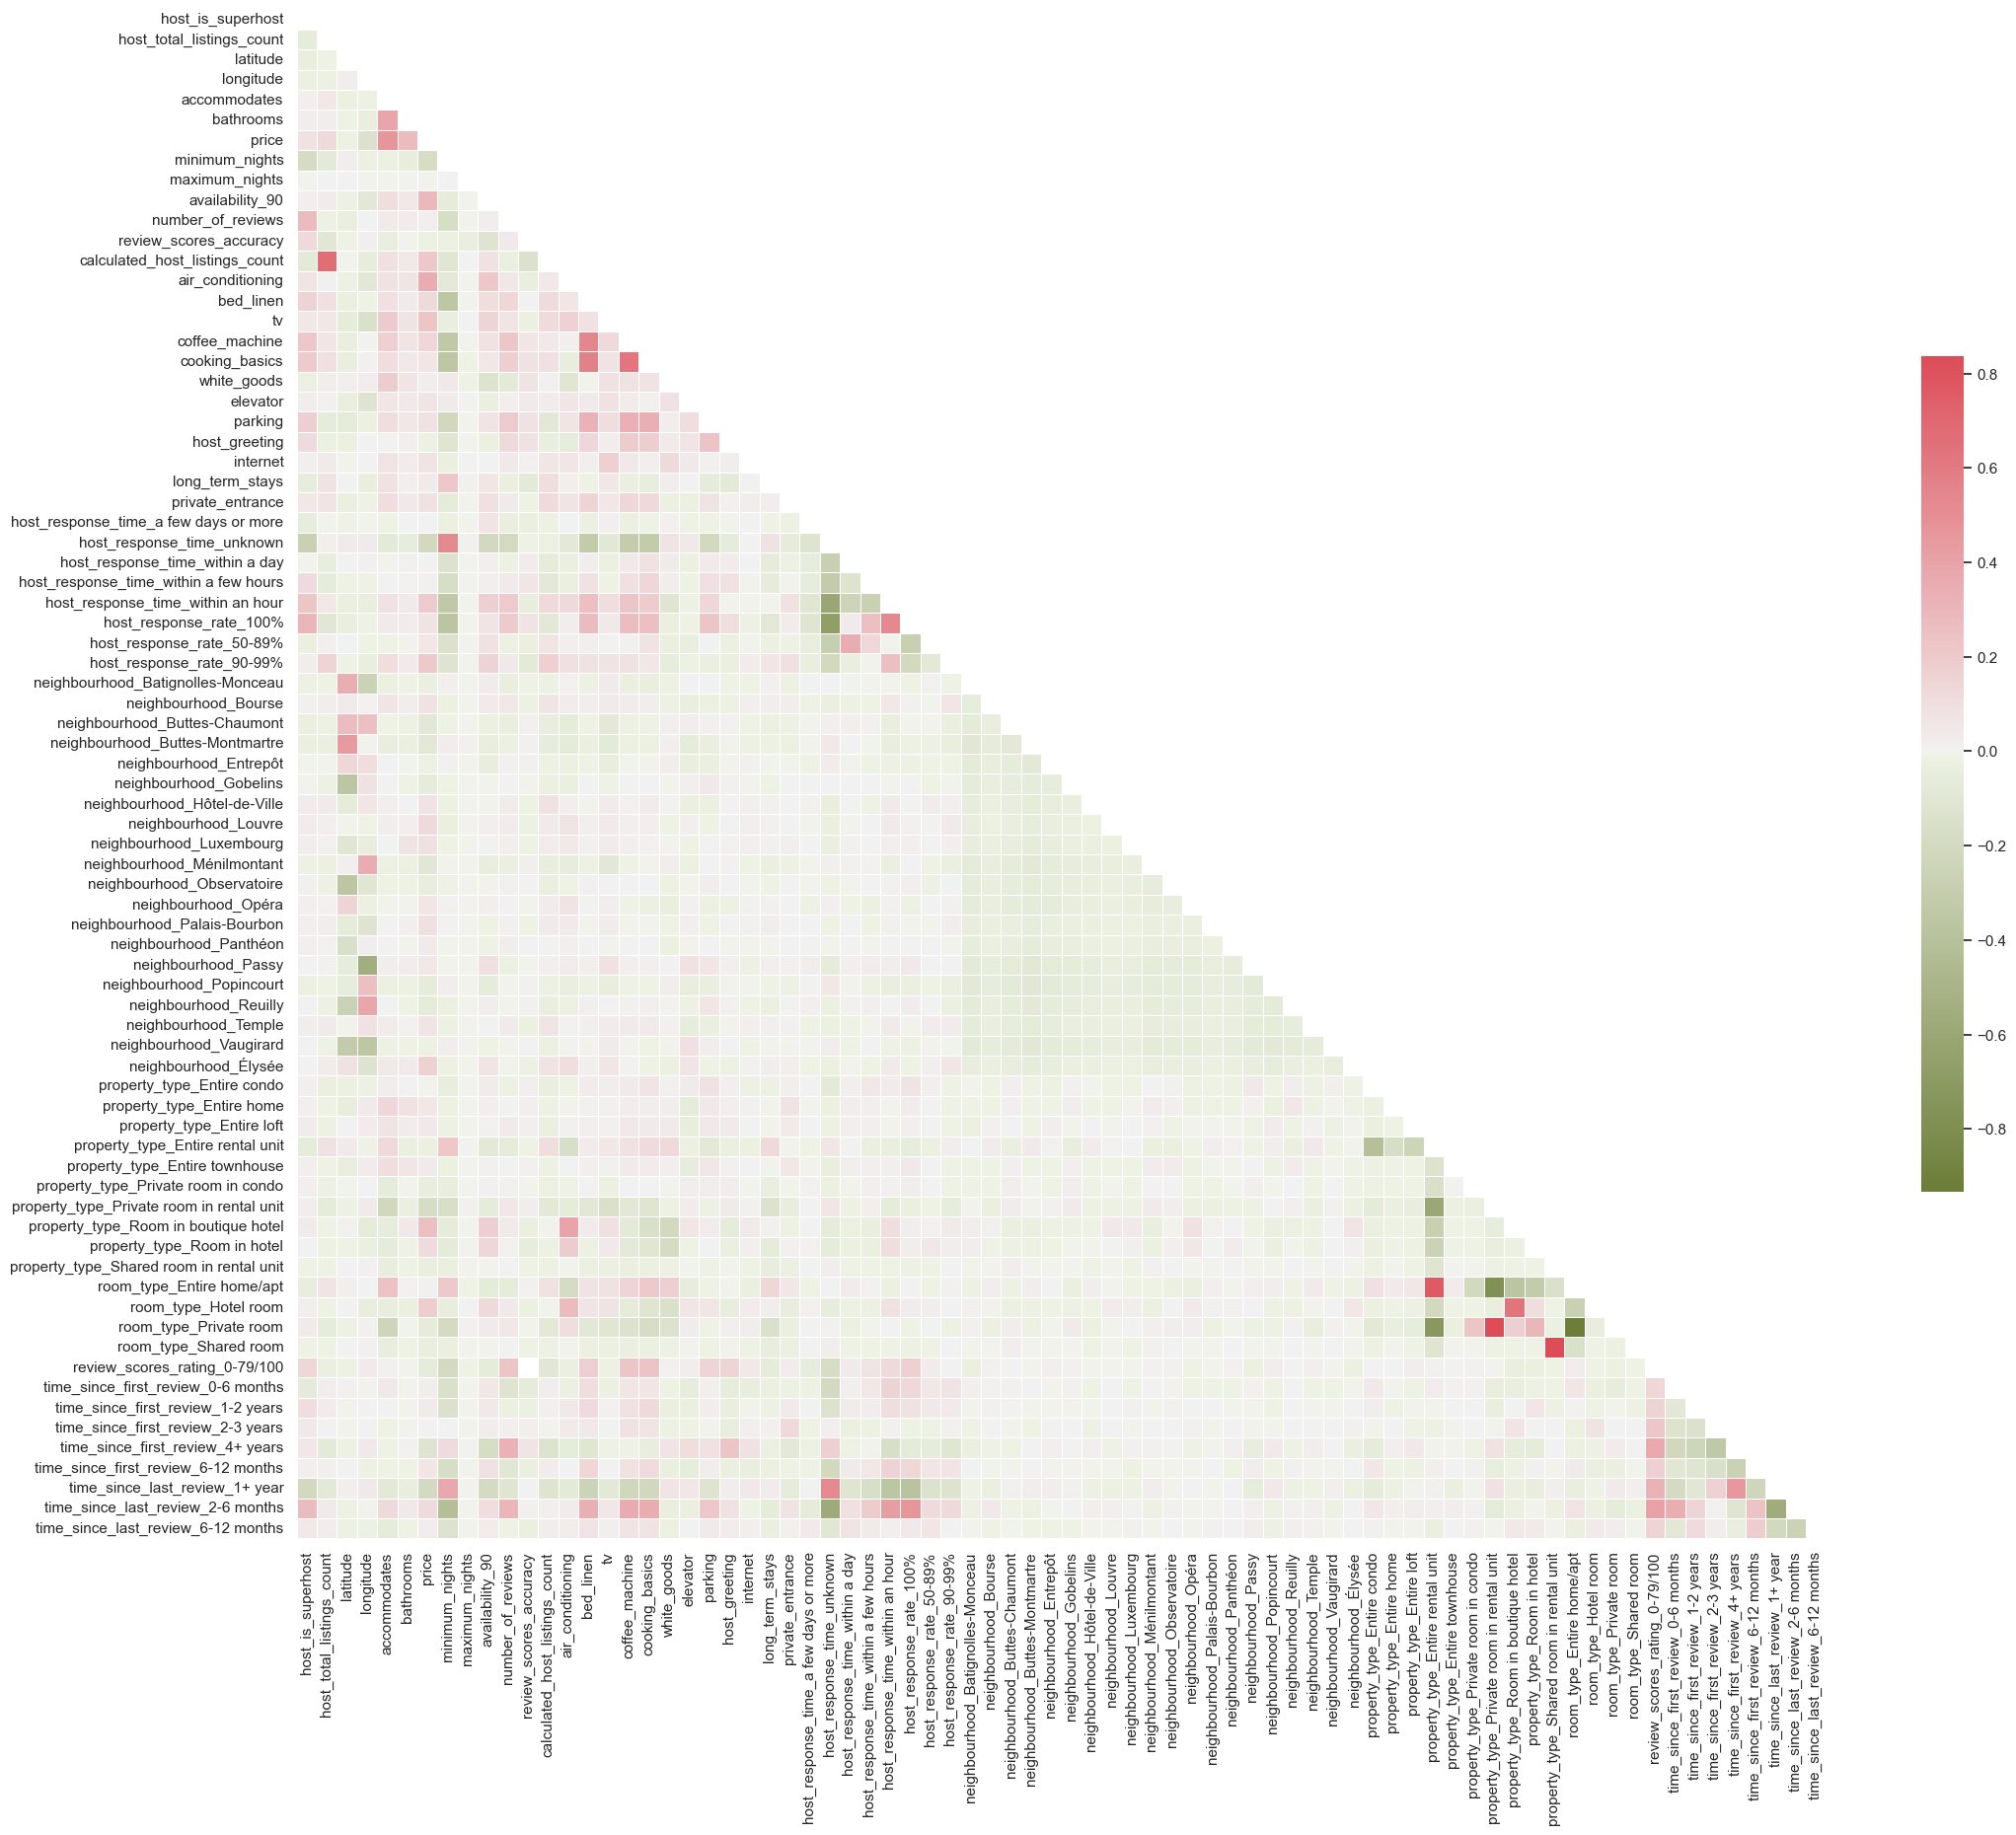

In [480]:
multi_collinearity_heatmap(df_.drop(list(df_.columns[df_.columns.str.endswith('0-8/10')]), axis=1), figsize=(25, 22))

### Scale data
Now, since we encoded all categorical features, removed Null values, the next step before fiting the model is to scale all data to get better numerical stability during learning.

Important point here! To avoid information leakage from future dataset we should split our data to train and test subsets. The scaler should fitted only on train data.

In [517]:
X = df_.drop(columns=["price"])
y = df_[["price"]]

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X = pd.DataFrame(feature_scaler.fit_transform(X), columns=list(X.columns))
y = target_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

In [519]:
sorted(X_train.columns)

['accommodates',
 'air_conditioning',
 'availability_90',
 'bathrooms',
 'bed_linen',
 'calculated_host_listings_count',
 'coffee_machine',
 'cooking_basics',
 'elevator',
 'host_greeting',
 'host_is_superhost',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'host_response_time_a few days or more',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_total_listings_count',
 'internet',
 'latitude',
 'long_term_stays',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'neighbourhood_Batignolles-Monceau',
 'neighbourhood_Bourse',
 'neighbourhood_Buttes-Chaumont',
 'neighbourhood_Buttes-Montmartre',
 'neighbourhood_Entrepôt',
 'neighbourhood_Gobelins',
 'neighbourhood_Hôtel-de-Ville',
 'neighbourhood_Louvre',
 'neighbourhood_Luxembourg',
 'neighbourhood_Ménilmontant',
 'neighbourhood_Observatoire',
 'neighbourhood_Opéra',
 'neighbourhood_Palais-

In [466]:
dump(target_scaler, open("target_scaler.pkl", "wb"))
dump(feature_scaler, open("feature_scaler.pkl", "wb"))

In [467]:
loaded_scaler = load(open('target_scaler.pkl', 'rb'))

In [469]:
loaded_scaler.scale_

array([149.99180702])

In [470]:
target_scaler.scale_

array([149.99180702])

## It is time to create a model!
What we have done so far:
- conducted extensive EDA
- removed or processed correlated or unnecessary features
- encoded categorical features using one hot encodin
- splited our dataset to train and test subsets
- scaled them both

Now everything is ready to create the first model to predict our target variable: **price per night** for a listing.

### What model baseline to choose?
In machine learning for regression task two most efficient architectures are RandomForestClassifier and Gradient Boosting. Gradient boosting algorithms are considered to be the best predicting models.

In [422]:
# scaled x and y

xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))

print("\nTraining RMSE:", round(mean_squared_error(y_train, tran_pred_xgb, squared=False), 4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_pred_xgb, squared=False), 4))

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

xgb_reg.save_model("airbnb_predictor.json")


Training MSE: 0.1493
Validation MSE: 0.2754

Training RMSE: 0.3864
Validation RMSE: 0.5248

Training r2: 0.8529
Validation r2: 0.7113


In [516]:
sorted(model2.feature_names_in_)

['accommodates',
 'air_conditioning',
 'availability_90',
 'bathrooms',
 'bed_linen',
 'calculated_host_listings_count',
 'coffee_machine',
 'cooking_basics',
 'elevator',
 'host_greeting',
 'host_is_superhost',
 'host_response_rate_100%',
 'host_response_rate_50-89%',
 'host_response_rate_90-99%',
 'host_response_time_a few days or more',
 'host_response_time_unknown',
 'host_response_time_within a day',
 'host_response_time_within a few hours',
 'host_response_time_within an hour',
 'host_total_listings_count',
 'internet',
 'latitude',
 'long_term_stays',
 'longitude',
 'maximum_nights',
 'minimum_nights',
 'neighbourhood_Batignolles-Monceau',
 'neighbourhood_Bourse',
 'neighbourhood_Buttes-Chaumont',
 'neighbourhood_Buttes-Montmartre',
 'neighbourhood_Entrepôt',
 'neighbourhood_Gobelins',
 'neighbourhood_Hôtel-de-Ville',
 'neighbourhood_Louvre',
 'neighbourhood_Luxembourg',
 'neighbourhood_Ménilmontant',
 'neighbourhood_Observatoire',
 'neighbourhood_Opéra',
 'neighbourhood_Palais-

In [524]:
def _predict(obj: pd.DataFrame,
             model_name="model/airbnb_predictor.json",
             target_scaler_name="model/target_scaler.pkl") -> float:
    """
    :param obj: object with features prepared for prediction
    :param model_name: name of file containing pretrained model
    :param target_scaler_name: name of file containing pretrained target scaler
    :return: float model price prediction
    """
    target_scaler_ = load(open(target_scaler_name, 'rb'))
    model = XGBRegressor()
    model.load_model(model_name)
    result = round(abs(model.predict(obj) * target_scaler_.scale_)[0])
    return result

In [526]:
X_train.sample()

,host_is_superhost,host_total_listings_count,latitude,longitude,accommodates,bathrooms,minimum_nights,maximum_nights,availability_90,number_of_reviews,...,room_type_Shared room,review_scores_rating_0-79/100,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months
31145,-0.377859,-0.197189,0.057468,-0.294136,-0.657905,-0.19785,-0.526319,-0.011905,-0.653182,-0.452445,...,-0.060444,0.484811,3.434819,-0.319607,-0.44693,-0.755807,-0.349437,-0.660781,1.17694,-0.307734


In [536]:
_predict(X_test.sample())

33


Training RMSE: 0.2768
Validation RMSE: 0.5254


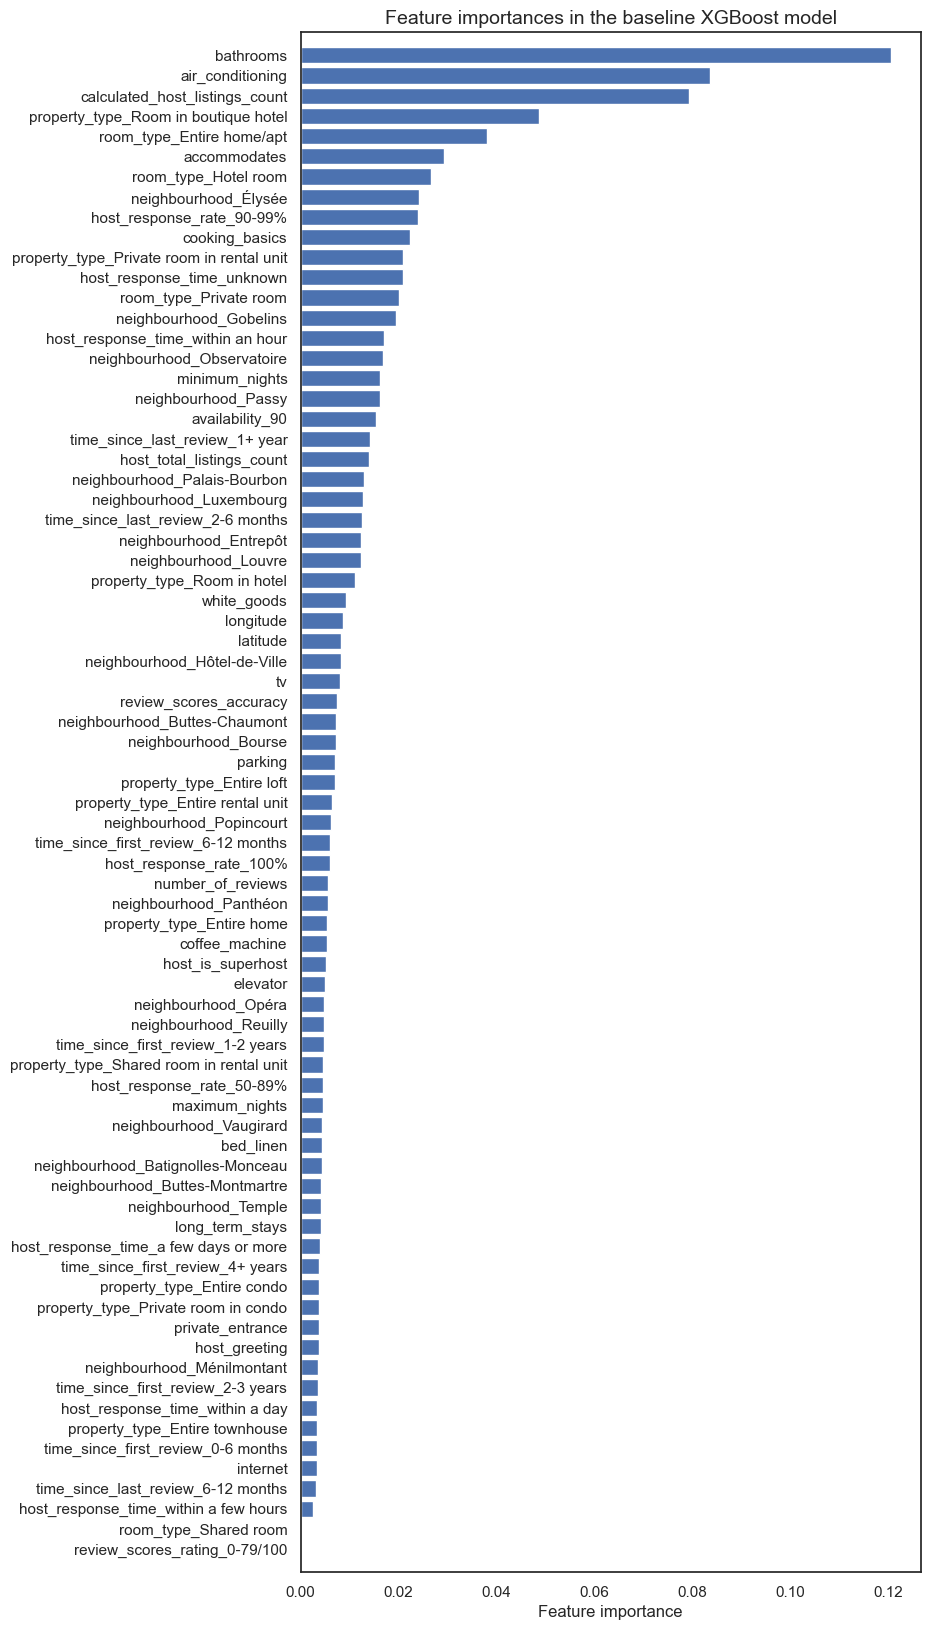

In [419]:
xgb_model = XGBRegressor(n_estimators=300)
xgb_model.fit(X_train, y_train)
tran_pred_xgb = xgb_model.predict(X_train)
val_pred_xgb = xgb_model.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, tran_pred_xgb, squared=False), 4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_pred_xgb, squared=False), 4))

ft_weights_xgb_reg = pd.DataFrame(xgb_model.feature_importances_, 
                                  columns=['weight'], 
                                  index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the baseline XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()


Training RMSE: 0.3864
Validation RMSE: 0.5248


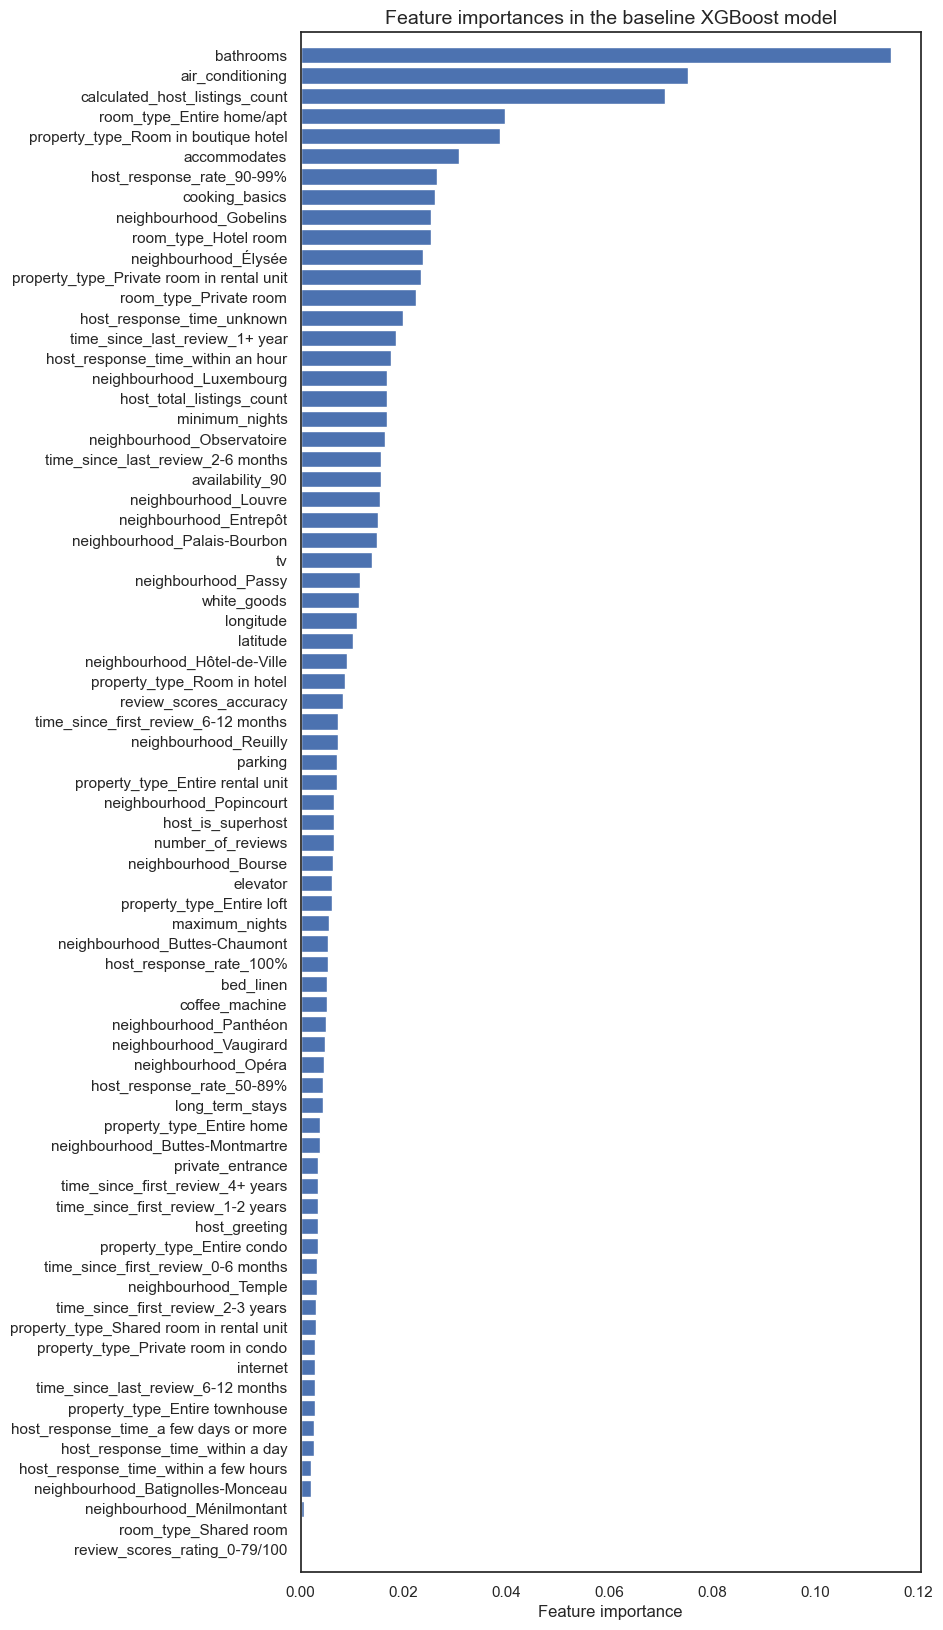

In [420]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
tran_pred_xgb = xgb_model.predict(X_train)
val_pred_xgb = xgb_model.predict(X_test)

print("\nTraining RMSE:", round(mean_squared_error(y_train, tran_pred_xgb, squared=False), 4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_pred_xgb, squared=False), 4))

ft_weights_xgb_reg = pd.DataFrame(xgb_model.feature_importances_, 
                                  columns=['weight'], 
                                  index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the baseline XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [20]:
xgb_model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

### Once we have a machine learning model baseline, we can conduct experiments on neural networks architecture using PyTorch framework

In [265]:
import torch
import random
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import pytorch_lightning as pl

In [254]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [367]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :]), self.y[idx]

In [314]:
X_train.shape

(44709, 75)

In [386]:
set_random_seed(42)

X = df_.drop(columns=["price"]).to_numpy()
y = df_[["price"]].to_numpy().squeeze(-1)

X = feature_scaler.fit_transform(X)
y = target_scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

train_set = MyDataset(X_train, y_train)
train_loader = DataLoader(train_set, batch_size=1024*2, shuffle=True)

test_set = MyDataset(X_test, y_test)
test_loader = DataLoader(test_set)

In [384]:
y_train

array([100., 256.,  90., ..., 229.,  78.,  93.])

In [361]:
# методы, используемые для обучения и тестирования нейросети

def fit(
    model, 
    optimizer, 
    criterion, 
    train_loader, 
    test_loader, 
    n_epochs=5, 
    scaler=target_scaler, 
    step_valid=5, 
    loss_to_stop=8.75):
    """
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
        n_epochs - number of epochs to fit the model
        scaler - sklearn.preprocessing scaler object to reshape predictions
            to irs oroginal scale
        step_valid - the step of validation
            For example if step_valid = 5, every fifth epoch validation results are printed
        loss_to_stop - value of test loss after reaching which we stop fitting the model
    """

    train_losses_per_epoch = []  # будем хранить пару [эпоха, лос ] на трейне в этом списке
    test_losses_per_epoch = []  # а на тесте тут 
    # обучение модели
    model.float()
    for epoch in tqdm(range(n_epochs)):
        train_loss = train_iteration(model, optimizer, criterion, train_loader)
        train_rmse = count_rmse(train_loss, scaler)  # посчитали рмсе за эпоху
        train_losses_per_epoch.append([epoch, train_rmse])

        # валидация модели в процессе обучения
        if epoch % step_valid == 0:  
            model.eval()
            predicts = test(model, criterion, test_loader)
            test_loss = criterion(torch.tensor(test_loader.dataset.y), predicts.reshape(-1))  # вектор тензор с ошибками на каждом объекте из теста
            test_rmse = np.sqrt(test_loss.item()) * scaler.scale_  # скаляр - значение самой ошибки
            test_losses_per_epoch.append([epoch, test_rmse])
            get_report(epoch, train_rmse, test_rmse)
            
            if test_rmse <= loss_to_stop:    #если достигли нужного лосса, останавливаемся
                break
                
    train_losses_per_epoch = np.array(train_losses_per_epoch, dtype=object)
    test_losses_per_epoch = np.array(test_losses_per_epoch, dtype=object)
    fit_result(test_losses_per_epoch)
    draw_report(train_losses_per_epoch, test_losses_per_epoch)


def train_iteration(model, optimizer, criterion, train_loader):
    """
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with test set
         ----------
        returns:
        losses - torch.tensor with shape (len(train_loader.dataset), ),
                   which contains losses for train objects
    """
    model.train()
    losses = torch.ones((len(train_loader), 1))
    idx = 0
    for x, y in train_loader:   # итерируемся по всем объектам датасета
        print("x", x)
        predicts = model(x)
        print("predicts ", predicts)
        loss = criterion(y, predicts.reshape(-1))  # получаем вектор тензор с ошибками на каждом объекте из трейна
        assert loss is not None
        losses[idx] = loss
        idx += 1
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    return losses


def test(model, criterion, test_loader, return_loss=False):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
        return_loss - bool parameter which determines if we return predictions and loss or loss only
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
        loss - [optional] If return_loss = True, function returns torch.tensor with shape (len(test_loader.dataset), ),
                   which contains the value of loss for each object in test set
    """
    loss = torch.ones(len(test_loader)) 
    preds = torch.ones(len(test_loader))
    with torch.no_grad():
        idx = 0
        for x_test, y_test in test_loader:
            cur_preds = model(x_test)
            cur_loss = criterion(y_test, cur_preds.reshape(-1))
            assert cur_loss is not None
            loss[idx] = cur_loss
            preds[idx] = cur_preds
            idx += 1
    if return_loss:
        return preds, loss
    else:
        return preds


def count_rmse(loss_tensor, scaler=None):
    # получили на вход вектор лоссов
    print(loss_tensor)
    if scaler is not None:
        # возвращаем рмсе в "изначальный масштаб" таргета
        return torch.sqrt(torch.sum(loss_tensor) / len(loss_tensor)).item() * scaler.scale_
    else:
        print(torch.sqrt(torch.sum(loss_tensor) / len(loss_tensor)).item())
        return torch.sqrt(torch.sum(loss_tensor) / len(loss_tensor)).item()


def get_report(epoch, train_loss, test_loss):
    print(f"Epoch {epoch}:\n"
          f"\tRMSE train: {round(train_loss[0], 4)}, "
          f"\tRMSE test: {round(test_loss[0], 4)}")


def fit_result(test_losses_per_epoch):
    best_loss = test_losses_per_epoch[:, 1].min().item()
    best_epoch = test_losses_per_epoch[test_losses_per_epoch[:, 1].argmin()][0]
    print(f"\nBest epoch {round(best_epoch)}, RMSE = {round(best_loss, 4)}")


def draw_report(train_losses_per_epoch, test_losses_per_epoch):
    fig, ax = plt.subplots()
    fig.set_size_inches(9, 6)
    plt.grid()
    plt.xlim(left=0, right=train_losses_per_epoch[-1][0])
    ax.plot(train_losses_per_epoch[:, 0], train_losses_per_epoch[:, 1], label="train loss")
    ax.plot(test_losses_per_epoch[:, 0], test_losses_per_epoch[:, 1], label="test loss")
    min_test_rmse = test_losses_per_epoch[:, 1].min().item()
    epoch_min_test_rmse = test_losses_per_epoch[test_losses_per_epoch[:, 1].argmin()][0]
    ax.scatter(epoch_min_test_rmse, min_test_rmse, color='red', s=40, marker='o', label="Min test loss")
    ax.legend()
    plt.xlabel("Номер эпохи")
    plt.ylabel("Значение лосса")
    plt.show()

In [387]:
# лучшая модель:
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 150),
#     nn.BatchNorm1d(150),
#     nn.Dropout(0.2),
#     nn.ReLU(),
#     nn.Linear(150, 100),
#     nn.BatchNorm1d(100),
#     nn.Dropout(0.2),
#     nn.ReLU(),
#     nn.Linear(100, 75),
#     nn.BatchNorm1d(75),
#     nn.Dropout(0.3),
#     nn.ReLU(),
#     nn.Linear(75, 50),
#     nn.BatchNorm1d(50),
#     nn.Dropout(0.2),
#     nn.ReLU(),
    nn.Linear(150, 1)
)

optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.001)
criterion = mse_loss

set_random_seed(42)
fit(model, optimizer, criterion, train_loader, test_loader, scaler=target_scaler, n_epochs=30, step_valid=1)

  0%|          | 0/30 [00:00<?, ?it/s]

x tensor([[ 0.0000,  2.0000, 48.8529,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  4.0000, 48.8592,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8528,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8925,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  7.0000, 48.8831,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8720,  ...,  0.0000,  1.0000,  0.0000]])
predicts  tensor([[     nan],
        [ -8.7622],
        [ -6.8329],
        ...,
        [ -2.0159],
        [-29.2352],
        [ -7.6583]], grad_fn=<AddmmBackward0>)
x tensor([[  0.0000,   1.0000,  48.8847,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   1.0000,  48.8839,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8543,  ...,   1.0000,   0.0000,   0.0000],
        ...,
        [  0.0000, 199.0000,  48.8163,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   1.0000,  48.8572,  ...,   0.0000,   1.0000,   0.0000],

x tensor([[  0.0000, 276.0000,  48.8433,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8796,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   2.0000,  48.8700,  ...,   1.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   1.0000,  48.8153,  ...,   0.0000,   0.0000,   1.0000],
        [  0.0000,   1.0000,  48.8688,  ...,   0.0000,   1.0000,   0.0000],
        [  1.0000,   9.0000,  48.8769,  ...,   0.0000,   0.0000,   1.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<CopySlices>)
Epoch 0:
	RMSE train: nan, 	RMSE te

Epoch 1:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  1.0000, 48.8570,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  4.0000, 48.8547,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8515,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8128,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  3.0000, 48.8918,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8495,  ...,  1.0000,  0.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 0.0000,  1.0000, 48.8366,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8887,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000, 70.0000, 48.8338,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 1.0000,  2.0000, 48.8824,  ...,  0.0000,  0.0000,  1.0000],
        [ 1.0000,  1.0000, 48.8655,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000

x tensor([[  0.0000,   1.0000,  48.8435,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   1.0000,  48.8599,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8437,  ...,   0.0000,   1.0000,   0.0000],
        ...,
        [  0.0000,   1.0000,  48.8704,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,  82.0000,  48.8835,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000, 446.0000,  48.8809,  ...,   0.0000,   0.0000,   0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[  0.0000, 158.0000,  48.8855,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8068,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8903,  ...,   0.0000,   0.0000,   1.0000],
        ...,
        [  0.0000,   1.0000,  48.8667,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8387,  ...,   0.0000,   0.0000,   1.

x tensor([[ 0.0000,  1.0000, 48.8850,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  1.0000, 48.8440,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  4.0000, 48.8384,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8891,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8968,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8489,  ...,  1.0000,  0.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<CopySlices>)
Epoch 3:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  1.0000,

x tensor([[ 0.0000,  1.0000, 48.8476,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  6.0000, 48.8734,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8922,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8698,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8669,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000, 48.9104,  ...,  0.0000,  1.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<CopySlices>)
Epoch 4:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  1.0000,

x tensor([[  0.0000,   1.0000,  48.8613,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000, 410.0000,  48.8571,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   3.0000,  48.8667,  ...,   1.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   1.0000,  48.8684,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8515,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   2.0000,  48.8916,  ...,   0.0000,   0.0000,   0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<CopySlices>)
Epoch 5:
	RMSE train: nan, 	RMSE te

Epoch 6:
	RMSE train: nan, 	RMSE test: nan
x tensor([[  0.0000, 116.0000,  48.8629,  ...,   0.0000,   0.0000,   1.0000],
        [  0.0000,   1.0000,  48.8656,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000, 410.0000,  48.8552,  ...,   0.0000,   1.0000,   0.0000],
        ...,
        [  0.0000,   2.0000,  48.8643,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   2.0000,  48.8508,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   2.0000,  48.8715,  ...,   1.0000,   0.0000,   0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 0.0000,  2.0000, 48.8601,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  4.0000, 48.8514,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 10.0000, 48.8696,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000, 94.0000, 48.8640,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8739,  ...,  1.0000,

Epoch 7:
	RMSE train: nan, 	RMSE test: nan
x tensor([[  0.0000,   3.0000,  48.8787,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   5.0000,  48.8163,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8625,  ...,   0.0000,   1.0000,   0.0000],
        ...,
        [  0.0000, 276.0000,  48.8710,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000, 276.0000,  48.8648,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   3.0000,  48.8419,  ...,   0.0000,   0.0000,   1.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 1.0000,  5.0000, 48.8052,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.9085,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8871,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8633,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8742,  ...,  0.0000,

Epoch 8:
	RMSE train: nan, 	RMSE test: nan
x tensor([[  0.0000,   6.0000,  48.8462,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   1.0000,  48.8970,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   3.0000,  48.8492,  ...,   1.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   3.0000,  48.8241,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000,   7.0000,  48.8618,  ...,   0.0000,   1.0000,   0.0000],
        [  0.0000, 274.0000,  48.8566,  ...,   0.0000,   0.0000,   0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 0.0000,  2.0000, 48.8667,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000, 48.8485,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  1.0000, 48.8866,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  2.0000, 48.8960,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8317,  ...,  0.0000,

Epoch 9:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  5.0000, 48.8385,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8940,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  3.0000, 48.8723,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000, 20.0000, 48.8629,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8240,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8105,  ...,  0.0000,  1.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 0.0000,  2.0000, 48.8941,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8504,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8841,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  3.0000, 48.8453,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8786,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000

Epoch 10:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  1.0000, 48.8397,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000, 48.8726,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8910,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 1.0000, 64.0000, 48.8683,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  7.0000, 48.8838,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  5.0000, 48.8474,  ...,  1.0000,  0.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[  0.0000,   2.0000,  48.8302,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   3.0000,  48.8846,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000, 134.0000,  48.8566,  ...,   0.0000,   0.0000,   1.0000],
        ...,
        [  0.0000,   1.0000,  48.8568,  ...,   1.0000,   0.0000,   0.0000],
        [  0.0000,   1.0000,  48.8394,  ...,   1.0000,   0.00

Epoch 11:
	RMSE train: nan, 	RMSE test: nan
x tensor([[ 0.0000,  1.0000, 48.8461,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  3.0000, 48.8888,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8519,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, 12.0000, 48.8675,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8672,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000, 84.0000, 48.8657,  ...,  0.0000,  0.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
x tensor([[ 0.0000,  1.0000, 48.8713,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 12.0000, 48.8574,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  2.0000, 48.8710,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8594,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.0000,  1.0000, 48.8637,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.000

x tensor([[ 0.0000,  1.0000, 48.8382,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000, 50.0000, 48.8766,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  3.0000, 48.8635,  ...,  1.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  1.0000, 48.8614,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000, 48.8543,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  2.0000, 48.8895,  ...,  0.0000,  1.0000,  0.0000]])
predicts  tensor([[nan],
        [nan],
        [nan],
        ...,
        [nan],
        [nan],
        [nan]], grad_fn=<AddmmBackward0>)
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], grad_fn=<CopySlices>)


KeyboardInterrupt: 

In [271]:
train_loader.dataset.y

array([[-0.3333009 ],
       [ 0.70675594],
       [-0.3999712 ],
       ...,
       [ 0.5267461 ],
       [-0.47997555],
       [-0.3799701 ]], dtype=float32)